In [230]:
#!/usr/bin/env python
# coding: utf-8

# In[58]:


import pyspark 
import random
from pyspark.sql import SQLContext, functions as func, types as typ
from pyspark.sql.functions  import explode, split, avg, col, desc, asc

sc = pyspark.SparkContext.getOrCreate() 
## Read the data into memory

sqlContest = SQLContext(sc)

mv1 = sqlContest.read.csv('ml-latest-small/movies.csv', header=True)
movies = sqlContest.read.csv('ml-latest-small/movies.csv', header=True)
links = sqlContest.read.csv('ml-latest-small/links.csv', header=True)
ratings = sqlContest.read.csv('ml-latest-small/ratings.csv', header=True)
tags = sqlContest.read.csv('ml-latest-small/tags.csv', header=True)
#print(mv1.first())
##Convert the timestamp to date

ratings = ratings.withColumn('RatingDate', func.date_format(ratings.timestamp.
                                                       cast(dataType= typ.LongType()).
                                                       cast(dataType= typ.TimestampType()),
                                                       "yyyy-MM-dd"))

tags = tags.withColumn('tagDate', func.date_format(tags.timestamp.
                                                       cast(dataType= typ.LongType()).
                                                       cast(dataType= typ.TimestampType()),
                                                   "yyyy-MM-dd"))

## Add genres columns using binary encoding for each category
genresLabels = ["Action", "Adventure", "Animation", "Children's", "Comedy"
                "Crime", "Documentary","Drama", "Fantasy", "Film-Noir",
                "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                "Thriller", "War", "Western"]

movies1 = movies
for label in genresLabels:
    movies = movies.withColumn(label, movies["genres"].like("%" + label +"%"))

#genres = movies.select("genres").distinct()

#genres.show()
#print(genres.count())
##Persist the data in memory
movies.persist()
links.persist()
ratings.persist()
tags.persist()

#Covert timestamp seconds to date


#print(ratings.count())
## Basic Requirements

# Search user by id, show the number of movies that he/she has watched
def searchUserByIdMovies(id):
    # Get distinct userID in ratings DF
    # Count distinct movie IDs for userID
    
    # Get distinct userID in tags DF
    # Count distinct movie IDs for userID

    # Combine counts from above two 

    return filtered

# Count the number of movies each userId has watched
def count_watched_movies():
    # Group by userId and movieId
    tagged_count = tags.groupBy("userId", "movieId").agg(func.countDistinct("tag").alias("taggedCount"))
    rated_count = ratings.groupBy("userId", "movieId").agg(func.countDistinct("rating").alias("ratedCount"))

    # Combine rows from ratings and tags tables
    rated_tagged_joined = tagged_count.join(rated_count, on=['userId', "movieId"], how ='fullouter')

    # Count unique number of movieIds per userId
    movies_watched_count = rated_tagged_joined.groupBy("userId").agg(func.countDistinct("movieId").alias("moviesWatched"))
    
    return movies_watched_count

# Count the number of genres each userId has watched
def count_watched_genres():
    # Group by userId and movieId
    tagged_count = tags.groupBy("userId", "movieId").agg(func.countDistinct("tag").alias("taggedCount"))
    rated_count = ratings.groupBy("userId", "movieId").agg(func.countDistinct("rating").alias("ratedCount"))

    # Combine rows from ratings and tags tables
    movies_watched = tagged_count.join(rated_count, on=['userId', "movieId"], how ='fullouter')

    # Combine with genres
    movies_watched_genres = movies_watched.join(movies, on=["movieId"], how='leftouter')
    
    # Split genres into array column
    movies_genres_split = movies_watched_genres.select(movies_watched_genres.userId, split(col("genres"), "[|]").alias("genresArray"))
    
    # Explode genres array into rows
    movies_watched_explode_genres = movies_genres_split.select(movies_genres_split.userId, explode("genresArray").alias("Genre"))
    
    # Group by userId, counting distinct number of genres watched
    genres_watched = movies_watched_explode_genres.groupBy("userId")\
                                                  .agg(func.countDistinct("Genre").alias("genresWatched"))\
                                                  .sort(func.desc("genresWatched"))
    genres_watched.show()

    return genres_watched

# Count the number of times users have watched each genre
def count_times_watched_genres():
    # Group by userId and movieId
    tagged_count = tags.groupBy("userId", "movieId").agg(func.countDistinct("tag").alias("taggedCount"))
    rated_count = ratings.groupBy("userId", "movieId").agg(func.countDistinct("rating").alias("ratedCount"))

    # Combine rows from ratings and tags tables
    movies_watched = tagged_count.join(rated_count, on=['userId', "movieId"], how ='fullouter')

    # Combine with genres
    movies_watched_genres = movies_watched.join(movies, on=["movieId"], how='leftouter')
    
    # Split genres into array column
    movies_genres_split = movies_watched_genres.select(col("userId"),col("movieId"), split(col("genres"), "[|]").alias("genresArray"))
    
    # Explode genres array into rows
    movies_watched_explode_genres = movies_genres_split.select(col("userId"),col("movieId"), explode("genresArray").alias("Genre"))
    
    # Group by userId and genre, counting distinct number of movies watched
    times_genres_watched = movies_watched_explode_genres.groupBy("userId", "Genre")\
                                                  .agg(func.countDistinct("movieId").alias("MoviesWatchedInGenre"))\
                                                  .sort(func.desc("userId"))

    return times_genres_watched


def count_watched_movies_user(id):
    movies_watched_count.where("userId = " + id).show()

def count_watched_genres_user(id):
    genres_watched_count.where("userId = " + id).show()

def get_titles_movies_watched_user(id):
    # Group by userId and movieId
    tagged_count = tags.groupBy("userId", "movieId").agg(func.countDistinct("tag").alias("taggedCount"))
    rated_count = ratings.groupBy("userId", "movieId").agg(func.countDistinct("rating").alias("ratedCount"))

    # Combine rows from ratings and tags tables
    movies_watched = tagged_count.join(rated_count, on=['userId', "movieId"], how ='fullouter')

    # Combine with movies table, which contains movie title
    movies_watched_titles = movies_watched.join(movies, on=["movieId"], how='leftouter')
    
    # View titles of movies watched, filtered by provided userId 
    movies_watched_titles = movies_watched_titles.select(movies_watched_titles.title)\
                            .where("userId = " + str(id))\
                            .show(200)

def get_number_users_watched_movie(movieId):
    # Group by userId and movieId
    tagged_count = tags.groupBy("userId", "movieId").agg(func.countDistinct("tag").alias("taggedCount"))
    rated_count = ratings.groupBy("userId", "movieId").agg(func.countDistinct("rating").alias("ratedCount"))

    # Combine rows from ratings and tags tables
    movies_watched = tagged_count.join(rated_count, on=['userId', "movieId"], how ='fullouter')

    # Combine with movies table, which contains movie title
    movies_watched_titles = movies_watched.join(movies, on=["movieId"], how='leftouter')

    # Get count of unique users by movieId
    unique_users_per_movie = movies_watched_titles.groupBy("movieId", "title")\
                            .agg(func.countDistinct("userId").alias("watchCount"))\
                            .sort(func.desc("watchCount"))
    unique_users_per_movie.show(50)

    # View titles of movies watched, filtered by provided userId 
    movies_watched_titles = unique_users_per_movie\
                            .filter(col("movieId") == str(movieId))\
                            .select(unique_users_per_movie.title, unique_users_per_movie.watchCount)\
                            .show()

def search_movies_by_genre(genre):
    # Split genres into array column
    movies_genres_split = movies.select(movies.movieId,movies.title, split(col("genres"), "[|]").alias("genresArray"))
    movies_genres_split.show()
    
    # Explode genres array into rows
    movies_watched_explode_genres = movies_genres_split.select(movies_genres_split.movieId, movies_genres_split.title, explode("genresArray").alias("genre"))
    movies_watched_explode_genres.show()

    # Select movies of particular genre 
    movies_watched_explode_genres.filter(col("genre") == genre)\
                                 .show()

def genres_ratings_avg_per_user():
    # combine tags with movies, linking ratings with genres
    movies_ratings = ratings.join(movies, on=["movieId"], how="leftouter")
    
    # Explode genres into rows
    movies_ratings_exploded_genre = movies_ratings\
                                    .select(col("userId"), col("title"), col("rating"), split(col("genres"), "[|]").alias("genresArray"))\
                                    .select(col("userId"), col("title"), col("rating"), explode("genresArray").alias("genre"))
    
    # Group by userId, genre -> avg rating
    genres_rating_avg = movies_ratings_exploded_genre.groupBy("userId", "genre")\
                            .agg(func.mean("rating").alias("AvgRating"))\
                            .sort(func.desc("userId"))
    #genres_rating_avg.show(30)
    return genres_rating_avg


def genres_ratings_count_per_user():
    # combine tags with movies, linking ratings with genres
    movies_ratings = ratings.join(movies, on=["movieId"], how="leftouter")
    
    # Explode genres into rows
    movies_ratings_exploded_genre = movies_ratings\
                                .select(col("userId"), col("title"), col("rating"), split(col("genres"), "[|]").alias("genresArray"))\
                                .select(col("userId"), col("title"), col("rating"), explode("genresArray").alias("genre"))
    
    # Group by userId, genre -> avg rating
    genres_rating_count = movies_ratings_exploded_genre.groupBy("userId", "genre")\
                            .agg(func.count("rating").alias("ratingsCount"))\
                            .sort(func.desc("userId"))
    #genres_rating_count.show(30)
    return genres_rating_count

# Combine users' avg rating per genre with the count of how many ratings they've made per genre
def genres_rated_count_avg_per_user():
    genres_rated_count_avg_per_user = genres_ratings_count_per_user()\
                                     .join(genres_ratings_avg_per_user(), on=["userId","genre"], how="leftouter")\
                                     .sort(col("AvgRating").desc())
    #genres_rated_count_avg_per_user.show()

    # Only consider genres which have a representative number of ratings
    return genres_rated_count_avg_per_user.filter(col("ratingsCount") > 10)





In [21]:
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)


## Visualisations
### Distributions
* Distribution of avg rating per genre
* Distribution of avg rating per film
* Distribution of avg rating per user

### Compare ratings of genres per user
* Bar chart showing ratings

### Compare number of watches per genre per user
* Bar chart showing comparison

### Which genres are peoples favourite?
* Pie chart (shows percetage)
* Bar chart (better for direct comparison comparison) (show number of users) 

### How does selected user rate each genre


In [218]:
def visualise_user_ratings_genres(userId):
    genre_ratings = genres_ratings_avg_per_user()\
                        .filter(col("userId") == userId)\
                        .sort(desc("genre"))\
                        .toPandas()

    plt.figure(figsize=(24,5))
    plt.bar(genre_ratings["genre"].to_list(), genre_ratings["AvgRating"].to_list())
    plt.xticks(rotation = -30)
    plt.title("How user with id " + userId + " rated each genre")
    plt.ylabel("Rating")
    plt.ylim([0,5.5])
    plt.show()

    

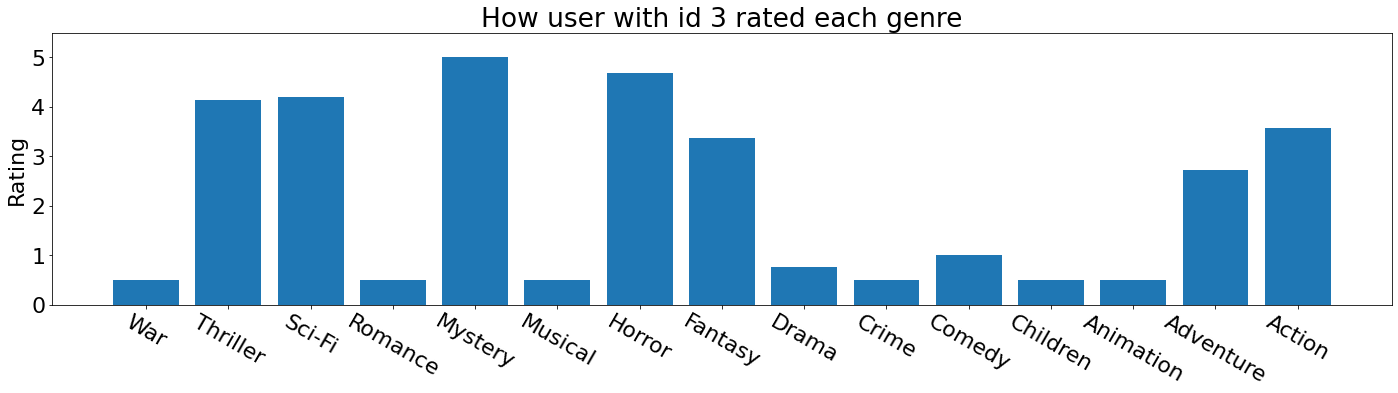

In [219]:
visualise_user_ratings_genres("3")

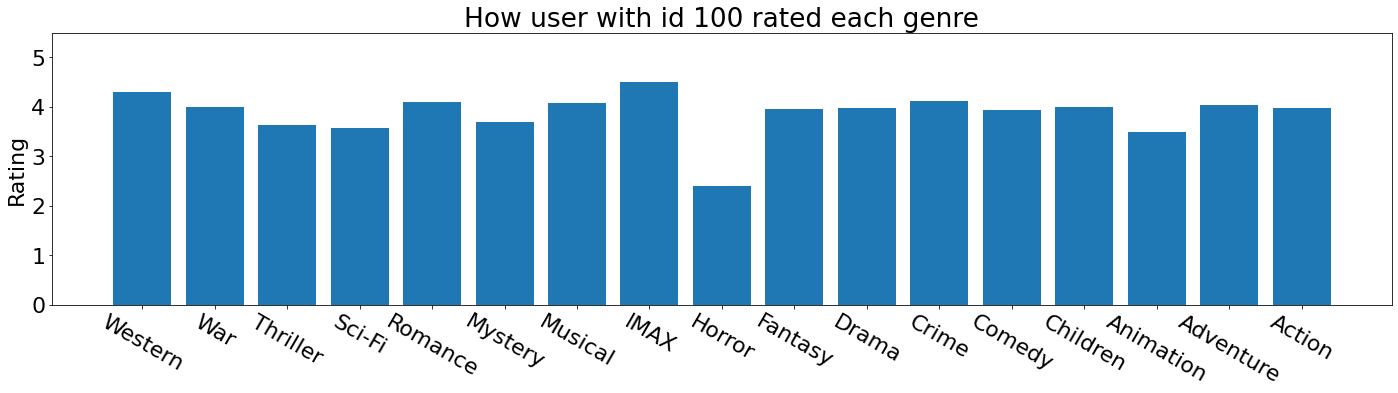

In [220]:
visualise_user_ratings_genres("100")

### How many movies has selected user watched of each genre

In [241]:
# How many movies has selected user watched of each genre
def visualise_times_user_watched_genres(userId):
    count_watches_genres = count_times_watched_genres()\
                        .filter(col("userId") == userId)\
                        .sort(desc("Genre"))\
                        .toPandas()

    plt.figure(figsize=(24,5))
    plt.bar(count_watches_genres["Genre"].to_list(), count_watches_genres["MoviesWatchedInGenre"].to_list())
    plt.xticks(rotation = -30)
    plt.title("How many movies user with id " + userId + " has watched of each genre")
    plt.ylabel("Number of movies")
    plt.show()

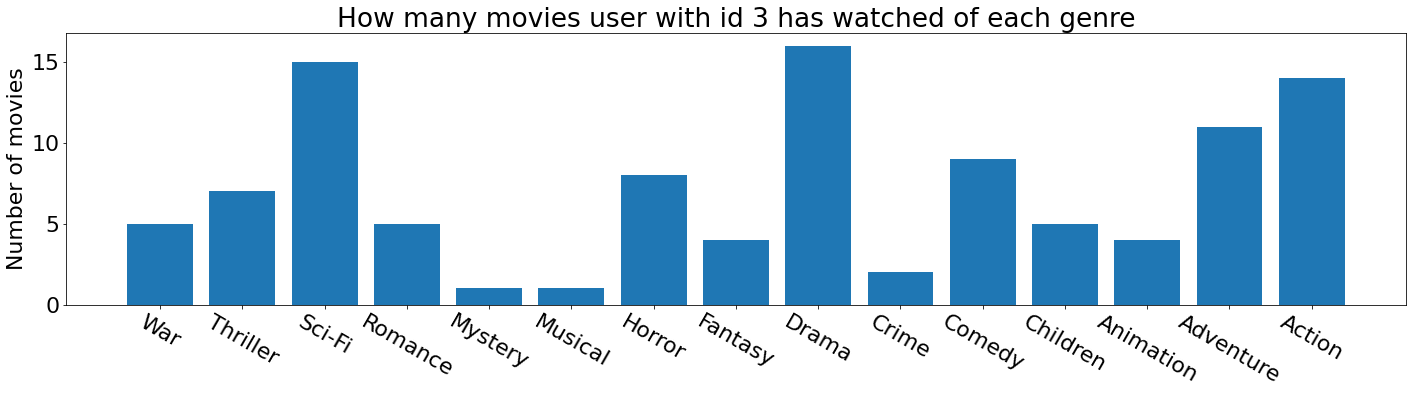

In [242]:
visualise_times_user_watched_genres("3")

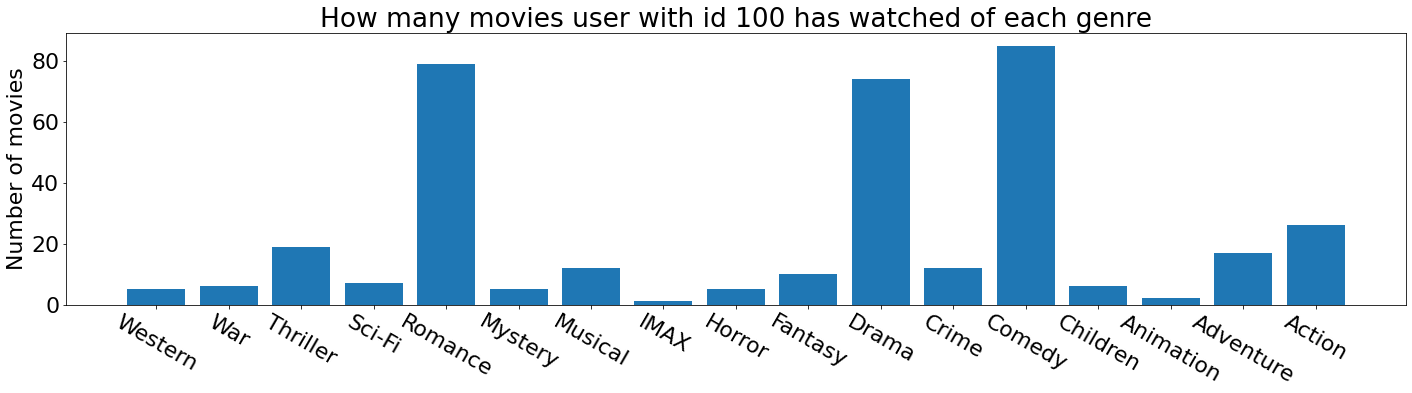

In [239]:
visualise_times_user_watched_genres("100")

In [237]:
count_times_watched_genres().show()

+------+---------+--------------------+
|userId|    Genre|MoviesWatchedInGenre|
+------+---------+--------------------+
|    99|      War|                   2|
|    99|   Horror|                   3|
|    99|    Crime|                  14|
|    99|     IMAX|                   1|
|    99|    Drama|                  18|
|    99| Thriller|                  21|
|    99|  Romance|                  10|
|    99|  Western|                   3|
|    99|  Mystery|                   3|
|    99|Adventure|                   9|
|    99|   Sci-Fi|                   6|
|    99|   Action|                  21|
|    99|Animation|                   1|
|    99|  Musical|                   1|
|    99| Children|                   1|
|    99|   Comedy|                  23|
|    98|   Horror|                  11|
|    98|  Mystery|                   5|
|    98|  Fantasy|                  19|
|    98|  Romance|                  16|
+------+---------+--------------------+
only showing top 20 rows



### Which genres are users' favourites?


In [232]:
def favourite_genres_count():
    return genres_rated_count_avg_per_user().groupBy(["genre", "userId"])\
                                 .agg(func.max("AvgRating").alias("FavouriteGenre"))\
                                 .groupBy("genre").agg(func.count("FavouriteGenre").alias("favouriteGenreCount"))\
                                 .sort(func.desc("favouriteGenreCount"))

In [233]:

def visualise_favourite_genres():
    pandasDf = favourite_genres_count().toPandas()
    plt.figure(figsize=(24,5))
    plt.bar(pandasDf["genre"].to_list(), pandasDf["favouriteGenreCount"].to_list())
    plt.xticks(rotation = -30)
    plt.title("How many users have genre as their favourite genre")
    plt.ylabel("Number of users")
    plt.show()


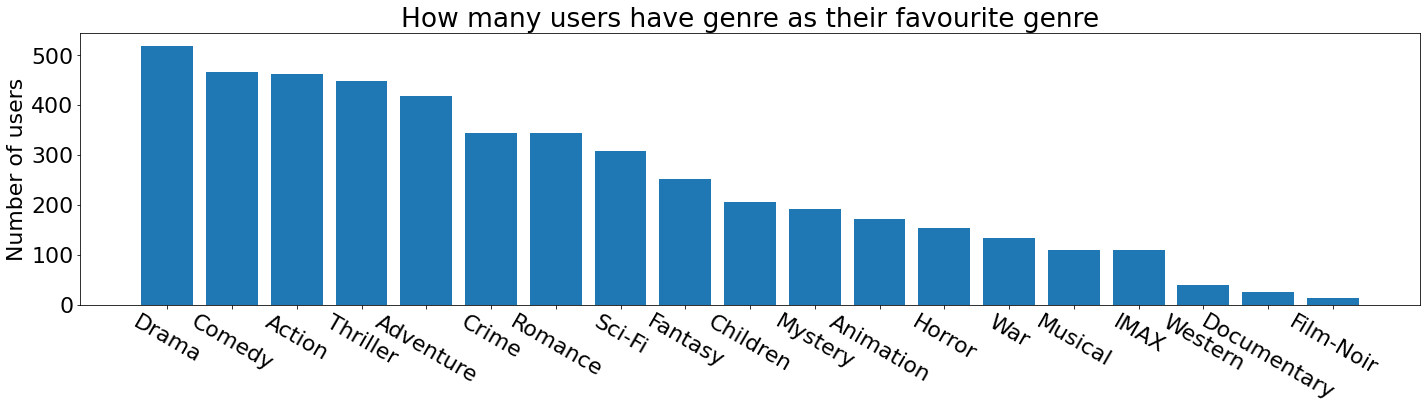

In [234]:
visualise_favourite_genres()

## Which genres are most watched by all users

In [258]:
# How many users have watched movies within each genre
def visualise_times_watched_genres_all_users():
    count_users_watched_genres = count_times_watched_genres()\
                        .groupBy(col("Genre"))\
                        .agg(func.sum("MoviesWatchedInGenre").alias("Count"))\
                        .sort(asc("Genre"))\
                        .toPandas()

    plt.figure(figsize=(24,5))
    plt.bar(count_users_watched_genres["Genre"].to_list(), count_users_watched_genres["Count"].to_list())
    plt.xticks(rotation = -60)
    plt.title("How many users have watched movies within each genre")
    plt.ylabel("Number of users")
    plt.show()

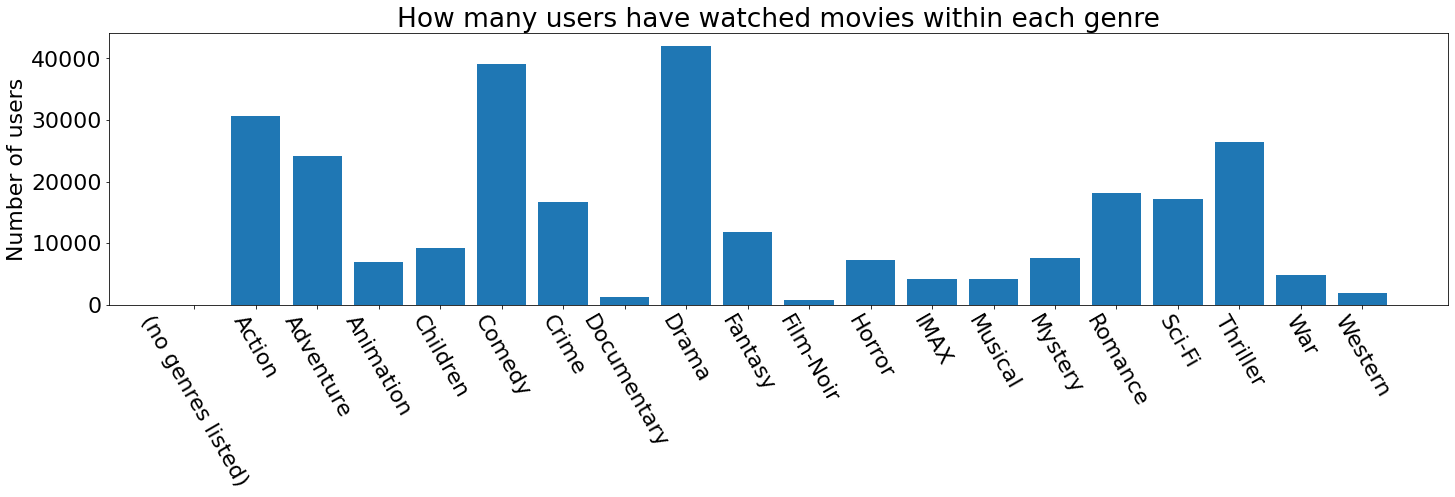

In [257]:
visualise_times_watched_genres_all_users()

In [246]:
count_times_watched_genres().show()

+------+---------+--------------------+
|userId|    Genre|MoviesWatchedInGenre|
+------+---------+--------------------+
|    99|Animation|                   1|
|    99|      War|                   2|
|    99|   Sci-Fi|                   6|
|    99|    Drama|                  18|
|    99| Thriller|                  21|
|    99|   Horror|                   3|
|    99|  Romance|                  10|
|    99|     IMAX|                   1|
|    99|  Mystery|                   3|
|    99| Children|                   1|
|    99|  Western|                   3|
|    99|    Crime|                  14|
|    99|  Musical|                   1|
|    99|   Action|                  21|
|    99|Adventure|                   9|
|    99|   Comedy|                  23|
|    98|   Action|                  28|
|    98|  Romance|                  16|
|    98|  Fantasy|                  19|
|    98| Children|                  20|
+------+---------+--------------------+
only showing top 20 rows



## Distribution of ratings per selected genre (marmite effect on genres)

In [231]:
# Distribution of users' average rating for selected genre
def visualise_distribution_ratings_genre_avg_user(genre):
    # Get the average ratings users have given per genre
    avg_user_ratings_genre_list =  genres_rated_count_avg_per_user()\
                                               .filter(col("genre") ==  genre)\
                                               .toPandas()["AvgRating"]
    
    
    # Plot into histogram
    fig, ax = plt.subplots()
    ax.hist(avg_user_ratings_genre_list)
    ax.set_title("Distribution of users' avg rating of the genre: " + genre)
    plt.show()
    
    

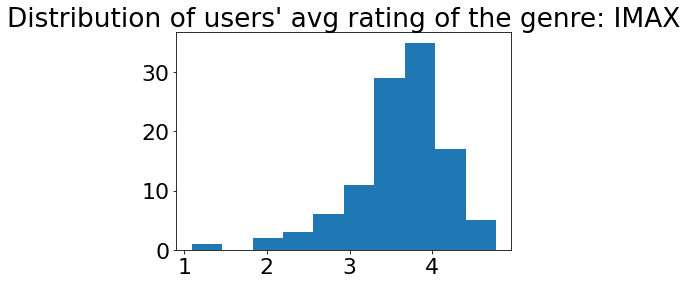

In [128]:
distribution_ratings_genre_avg_user("IMAX")

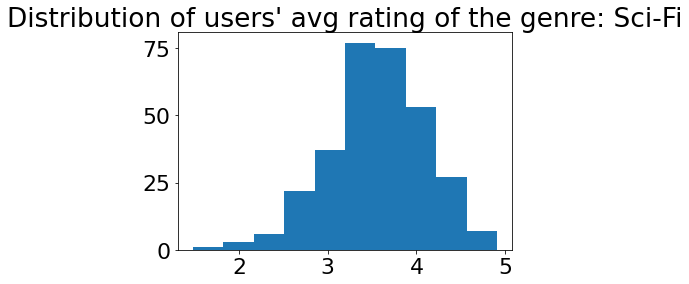

In [178]:
distribution_ratings_genre_avg_user("Sci-Fi")

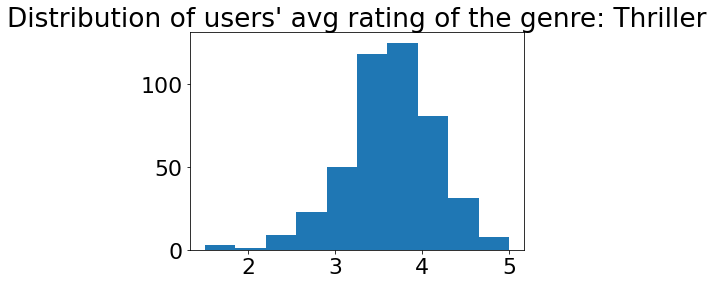

In [179]:
distribution_ratings_genre_avg_user("Thriller")

## Distribution of ratings per movie

## What kinds of ratings do users give

In [176]:
# Distribution of all ratings given
def visualise_distribution_all_ratings():
    # Get the average ratings users have given per genre
    ratings_list =  ratings.sort(col("rating").asc()).toPandas()["rating"].to_list()
    
    # Plot into histogram
    fig, ax = plt.subplots()
    plt.hist(ratings_list, bins=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

    ax.set_title("Distribution of rating given")
    plt.show()
    
    

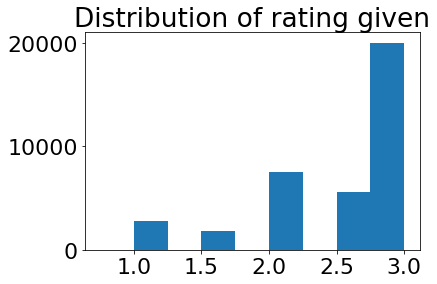

In [177]:
visualise_distribution_all_ratings()